<a href="https://colab.research.google.com/github/ialara/actf/blob/f22-excursion/f22_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guts

## Imports

The fewer and more mainstream the imports, the less likely to cause headaches on AF systems.

In [1]:
import numpy as np
from collections import Counter
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import pandas as pd
import datetime
rng = np.random.default_rng()

## Simulation Parameters

Up front! There are two types of simulation parameters:
* Structural parameters (listed below): Designed to be "under-the-hood" parameters set by developers for each MDS, not varying across end-user scenario inputs.
* Scenario parameters (defined later): Designed to be the end-user "GUI"-able inputs to explore different scenarios.

In [2]:
mds_name = 'F-22'
mds_sorties_from_ftu = 38 # Count toward experiencing. Based on FTU syllabus rides.

#############################
## Squadron Initialization ##
#############################
# Uniform draw
init_sq_inx_tos_min = 0
init_sq_inx_tos_max = 36
init_sq_exp_tos_min = 0
init_sq_exp_tos_max = 36

# Uniform draw, capped by TOS/SCM dependency.
init_sq_inx_mds_sorties_min = mds_sorties_from_ftu
init_sq_inx_scm_limit = 9 # Assume upper bound of x sorties per month on station
init_sq_inx_mds_sorties_max = init_sq_inx_mds_sorties_min + init_sq_inx_scm_limit*init_sq_inx_tos_max 

# Uniform draw
init_sq_exp_mds_sorties_min = 250 # <-- setting based on Syllabus.exp_sortie_rqmt breaks if exploring definition with no sortie minimum
init_sq_exp_mds_sorties_max = 600 # Arbitrary ub

init_mqt_complete_tos_min = 2 # Assumes initial pilots complete MQT within specified timeline (of x months). Pilots < x TOS are enrolled in MQT (up to capacity).

init_ip_mds_sorties_min = 284 # EXP pilots meeting minimum x MDS sorties are assigned as IPs up to initial IP count.


#############################
## Inflow Pilot Parameters ##
#############################
ftu_inflow_mds_sortie_plus_minus = 5 # from FTU sortie parameter.
xflow_WG_mds_sorties_min = 200
xflow_WG_mds_sorties_max = 240 # (90% of original EXP 250 sortie minimum)
xflow_2FL_mds_sorties_min = xflow_WG_mds_sorties_max
xflow_2FL_mds_sorties_max = 300
xflow_4FL_mds_sorties_min = xflow_2FL_mds_sorties_max
xflow_4FL_mds_sorties_max = 500
xflow_IP_mds_sorties_min = 375
xflow_IP_mds_sorties_max = 1000

xflow_IP_pct = 0.3
xflow_WG_pct = 0.2

##########################################
## Upgrade Enrollment Probability Ramps ##
##########################################
# A measure of CC discretion in determining when pilots are "ready" to start
# various upgrades. At each MDS sortie "chunk" a pilot has a certain chance of
# enrollment into the upgrade (assuming available space). As pilots accumulate
# sorties to put them into the next "chunk," their enrollment probability increases
# (they are more likely to be "ready"), up to a defined maximum chance. Note, the
# simulation separately constrains simultaneous upgrade enrollment to a certain 
# program capacity -- this input should only capture the "readiness"/aptitude of
# a pilot based roughly on their MDS sorties.
#
# For example, one way to think of it is "50% of pilots with 200-229 sorties are ready to start FLUG,"
# "80% of pilots with 260-299 sorties are ready to start FLUG." Alternatively,
# "each pilot with 200-229 sorties has a 50% chance of being deemed ready for FLUG,"
# "each pilot with 260-299 sorties has an 80% chance of being deemed ready for FLUG."
# Statistically, these inputs define the discrete cdf of the upgrade readiness probability distribution.

min_mds_sorties_2flug = 145
enrolment_prob_at_minimum_2flug = 0.5
sortie_chunk_size_2flug = 30
enrolment_prob_increment_per_chunk_2flug = 0.15
enrolment_prob_max_2flug = 0.99

min_mds_sorties_4flug = 175
enrolment_prob_at_minimum_4flug = 0.5
sortie_chunk_size_4flug = 30
enrolment_prob_increment_per_chunk_4flug = 0.15
enrolment_prob_max_4flug = 0.99

min_mds_sorties_ipug = 275
enrolment_prob_at_minimum_ipug = 0.5
sortie_chunk_size_ipug = 30
enrolment_prob_increment_per_chunk_ipug = 0.15
enrolment_prob_max_ipug = 0.99

###########################
## Time-on-station limit ##
###########################
tos_limit_months = 36

#####################################
## Absorption Importance (% tails) ##
#####################################
daily_INX_tails_pct = 0.3




## Definitions and Classes

In [3]:
class Pilot:
    ftu_sorties = mds_sorties_from_ftu # Sortie Flow F-22 xlsx
    def __init__(self, i, mds_sorties=mds_sorties_from_ftu, tos=0, experienced=False):
        self.id = i
        self.mds_sorties = mds_sorties
        self.tos = tos
        self.experienced = experienced
        self.arrived_month = 0
        self.in_ug = False
        self.ug = None
        self.ride_num = None
        self.quals = []
        self.tte = 0

    def set_arrived_month(self, month):
        self.arrived_month = month

    def increment_tos(self, months=1):
        self.tos += months

    def increment_mds_sorties(self, sortie_increment=1):
        self.mds_sorties += sortie_increment
        if self.in_ug:
          self.ride_num += sortie_increment

    def enroll_in_ug(self, ug, start_month=0):
        if self.in_ug:
            #print(f'PID {self.id} already enrolled in {self.ug}. {f"Did not enroll in {ug}." if self.ug != ug else ""}')
            return
        self.in_ug = True
        self.ug = ug
        self.ug_start_month = start_month
        self.ride_num = 0
        #print(f'PID {self.id} enrolled in {self.ug}.')
      
    def disenroll_from_ug(self):
        self.in_ug = False
        self.ug = None
        self.ride_num = None

    def award_qual(self, qual):
        if qual not in self.quals:
            self.quals.append(qual)

    def print_(self):
        msg = [f'ID: {self.id:2d} | EXP: {"Y" if self.experienced else "N"} | ',
               f'TOS: {self.tos:2d} | STY: {self.mds_sorties:3d} | ARR: {self.arrived_month:3d} | ',
               f'TTE: {self.tte if self.experienced else "- ":2} | QUAL: {self.quals}']
        if self.ug is not None:
            msg.append(f' | UG: {self.ug} #{self.ride_num}')

        print(*msg)

class Squadron:
    def __init__(self, name='default_Squadron', syllabi=None):
        self.name = name
        self.pilots = []
        self.gone_pilots = []
        self.absorbed_pilots = []
        self.pid = 0
        if syllabi is None:
            self.syllabi = {}
        else:
            self.syllabi = syllabi

    def assign_pilot(self, pilot, arrived_month=0):
        self.pilots.append(pilot)
        pilot.set_arrived_month(arrived_month)

    def add_syllabi(self, syllabi):
        self.syllabi = syllabi

    def set_syllabus_ug_capacity(self, syllabus, capacity):
        syllabus.capacity = capacity

    def set_monthly_sorties_available(self, capacity=240):
        self.monthly_sorties_available = capacity

    def _next_pid(self):
        self.pid += 1
        return self.pid

    def get_pilot_by_id(self, id):
        pilot_dict = {p.id: p for p in self.pilots}
        pilot_dict.update({p.id: p for p in self.gone_pilots})
        return pilot_dict[id]

    def get_pilots_by_qual(self):
        quals = np.asarray(self._get_highest_quals())
        pilots = np.asarray(self.pilots)
      
        return {q: list(pilots[quals == q]) for q in Counter(quals).keys()}


    def populate_initial(self, num_pilots=36, prop_EXP=0.6, prop_IP=0.3):
        # num_EXP = rng.binomial(num_pilots, prop_EXP)
        # num_IP = rng.binomial(num_EXP, prop_IP)
        # num_INX = num_pilots - num_EXP

        num_EXP = int(num_pilots*prop_EXP) # API-1 45% EXP x 26 pilots + API-6 100% EXP x 10 pilots
        num_IP = int(num_pilots*prop_IP)
        num_INX = num_pilots - num_EXP

        # Parameters
        min_TOS_INX = init_sq_inx_tos_min
        max_TOS_INX = init_sq_inx_tos_max
        min_TOS_EXP = init_sq_exp_tos_min
        max_TOS_EXP = init_sq_exp_tos_max

        min_sorties_INX = init_sq_inx_mds_sorties_min
        max_sorties_INX = init_sq_inx_mds_sorties_max
        min_sorties_EXP = init_sq_exp_mds_sorties_min
        max_sorties_EXP = init_sq_exp_mds_sorties_max

        # Assign INX pilots
        for _ in range(num_INX):
            my_tos = rng.integers(min_TOS_INX, max_TOS_INX)
            my_sorties = rng.integers(min_sorties_INX, max_sorties_INX)
            # Rough capping of sorties w/ TOS: Assume no more than x sorties per month
            # (Assume no "holdover" INX arrivals in initial population)
            my_sorties = min(my_sorties, min_sorties_INX + (my_tos+1)*init_sq_inx_scm_limit)
            inx_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos)
            inx_pilot.initial_tos = my_tos # Debugging initial population

            inx_pilot.inflow_source = 'initial'
            inx_pilot.absorbable = True
            if inx_pilot.tos > init_mqt_complete_tos_min: # Assume initial population completes MQT in specified timeline, and represents only first tour arrivals
                inx_pilot.increment_mds_sorties(self.syllabi['MQT'].duration)
                inx_pilot.award_qual(self.syllabi['MQT'].award)
                inx_pilot.inflow_source += f' {self.syllabi["MQT"].award}'

                two_fl_draw = rng.random()
                if (inx_pilot.mds_sorties >= min_mds_sorties_2flug + self.syllabi['2FLUG'].duration) and (rng.random() <
            min(enrolment_prob_at_minimum_2flug + int((inx_pilot.mds_sorties - min_mds_sorties_2flug) / sortie_chunk_size_2flug)*enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug)):
                    inx_pilot.award_qual(self.syllabi['2FLUG'].award)
                    inx_pilot.inflow_source += f'/{self.syllabi["2FLUG"].award}'

            else: # These are new arrivals - assume all initial INX with 0 or 1 TOS
                  # are from FTU
                my_ug_prog = rng.integers(self.syllabi['MQT'].duration) # MQT and FLUG have same duration
                # Assumptions: INX arrivals with 0 or 1 TOS are either new from FTU,
                # or "hold-overs" arriving INX from previous location
                ##if inx_pilot.f16_sorties < 75:
                inx_pilot.enroll_in_ug('MQT')
                #self.syllabi['MQT'].capacity -= 1
                inx_pilot.increment_mds_sorties(my_ug_prog)
                # elif inx_pilot.f16_sorties < 200:
                #     inx_pilot.award_qual('WG')
                #     inx_pilot.inflow_source += ' WG'
                #     if rng.random() < 0.7:
                #         inx_pilot.enroll_in_ug('FLUG')
                #         #self.syllabi['FLUG'].capacity -= 1
                #         inx_pilot.increment_f16_sorties(my_ug_prog)
                #         inx_pilot.inflow_source += '/FLUG'

                # else:
                #     inx_pilot.award_qual('WG')
                #     if rng.random() < 0.7:
                #         inx_pilot.award_qual('FL')
                #         inx_pilot.inflow_source += ' FL'
            self.assign_pilot(inx_pilot, arrived_month=-1*inx_pilot.tos)
          
        # Assign EXP pilots
        ips_remaining = num_IP
        for _ in range(num_EXP):
            my_tos = rng.integers(min_TOS_EXP, max_TOS_EXP)
            my_sorties = rng.integers(min_sorties_EXP, max_sorties_EXP)
            exp_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos,
                              experienced = True)
            exp_pilot.award_qual(Syllabus.exp_qual_rqmt)
            exp_pilot.absorbable = False
            if exp_pilot.mds_sorties >= init_ip_mds_sorties_min and ips_remaining > 0: #275 based on Slab desired changes + 9 for IPUG -- make a parameter
                exp_pilot.award_qual('IP')
                ips_remaining -= 1
            # elif exp_pilot.f16_sorties >= 275:
            #     ipug_prob = min(1, 0.6 + int((exp_pilot.f16_sorties - 275)/30)*.15)
            #     if rng.random() < ipug_prob:
            #       exp_pilot.enroll_in_ug('IPUG')
            #       #self.syllabi['IPUG'].capacity -= 1
            #       exp_pilot.increment_f16_sorties(rng.integers(9))
            exp_pilot.initial_tos = my_tos
            self.assign_pilot(exp_pilot, arrived_month=-1*exp_pilot.tos)

    def inflow_from_ftu(self, num_pilots=15, arrival_month=0):
        new_ftus = []
        for _ in range(num_pilots):
            ftu_sortie_delta = rng.integers(-1*ftu_inflow_mds_sortie_plus_minus, ftu_inflow_mds_sortie_plus_minus)
            my_mds_sorties = Pilot.ftu_sorties + ftu_sortie_delta
            new_pilot = Pilot(self._next_pid(), mds_sorties = my_mds_sorties)
            new_pilot.inflow_source = 'FTU'
            new_pilot.absorbable = True
            self.assign_pilot(new_pilot, arrived_month=arrival_month)
            new_ftus.append(new_pilot)
        
        return new_ftus

    def inflow_nth_tour(self, num_pilots=20, prop_IP=xflow_IP_pct, prop_WG=xflow_WG_pct, arrival_month=0):
        num_IP = rng.binomial(num_pilots, prop_IP)
        num_WG = rng.binomial(num_pilots, prop_WG)
        num_4FL = num_pilots - num_IP - num_WG

        # Parameters
        min_sorties_WG = xflow_WG_mds_sorties_min
        max_sorties_WG = xflow_WG_mds_sorties_max
        min_sorties_4FL = xflow_4FL_mds_sorties_min
        max_sorties_4FL = xflow_4FL_mds_sorties_max
        min_sorties_IP = xflow_IP_mds_sorties_min
        max_sorties_IP = xflow_IP_mds_sorties_max

        new_nth = []
        for _ in range(num_IP):
            my_sorties = rng.integers(min_sorties_IP, max_sorties_IP)
            new_IP = Pilot(self._next_pid(), mds_sorties = my_sorties, experienced=True)
            new_IP.award_qual(Syllabus.exp_qual_rqmt)
            new_IP.award_qual('IP')
            self.assign_pilot(new_IP, arrived_month=arrival_month)
            new_IP.absorbable = False
            new_nth.append(new_IP)

        for _ in range(num_4FL):
            my_sorties = rng.integers(min_sorties_4FL, max_sorties_4FL)
            new_4FL = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_4FL.award_qual('4FL')
            new_4FL.experienced = Syllabus.meets_EXP_criteria(new_4FL.mds_sorties, new_4FL.quals)
            new_4FL.inflow_source = 'nth tour'
            self.assign_pilot(new_4FL, arrived_month=arrival_month)
            new_4FL.absorbable = False
            new_nth.append(new_4FL)

        for _ in range(num_WG):
            my_sorties = rng.integers(min_sorties_WG, max_sorties_WG)
            new_WG = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_WG.award_qual('WG')
            new_WG.inflow_source = 'nth tour'
            new_WG.absorbable = False
            self.assign_pilot(new_WG, arrived_month=arrival_month)
            new_nth.append(new_WG)
        
        return new_nth
            
    def inflow_pilots(self, num_ftu=15, num_nth_tour=5, arrival_month=0):
        new_ftus = self.inflow_from_ftu(num_ftu, arrival_month=arrival_month)
        new_nth = self.inflow_nth_tour(num_nth_tour, arrival_month=arrival_month)
        try:
            ips = self.get_pilots_by_qual()['IP']
            for p in ips:
                assert p.experienced, f'IP {p.id} is not experienced.'
        except KeyError:
             pass
        return new_ftus, new_nth

    def outflow_pilots(self, tos_threshold=36):
        removed_pilots = [p for p in self.pilots if p.tos >= tos_threshold]
        for p in removed_pilots:
            if p.absorbable:
                p.absorbed = False
        self.pilots = [p for p in self.pilots if p not in set(removed_pilots)]
        self.gone_pilots.extend(removed_pilots)
        return removed_pilots

    def enroll_ug_students(self, start_month=0):
        pilots_by_quals = self.get_pilots_by_qual()
        def _find_candidates(qual_prereq):
            candidates = []
            try:
                candidates = pilots_by_quals[qual_prereq]
            except KeyError:
                #print(f'Could not find any {qual_prereq}. Returning: {candidates}')
                pass
            return candidates

        mqt_candidates = _find_candidates('')
        two_flug_candidates = _find_candidates(self.syllabi['MQT'].award)
        two_flug_candidates = [p for p in two_flug_candidates if (p.mds_sorties >= min_mds_sorties_2flug) and (rng.random() <
            min(enrolment_prob_at_minimum_2flug + int((p.mds_sorties - min_mds_sorties_2flug) / sortie_chunk_size_2flug)*enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug))]
        four_flug_candidates = _find_candidates(self.syllabi['2FLUG'].award)
        four_flug_candidates = [p for p in four_flug_candidates if p.mds_sorties >= min_mds_sorties_4flug and (rng.random() <
            min(enrolment_prob_at_minimum_4flug + int((p.mds_sorties - min_mds_sorties_4flug) / sortie_chunk_size_4flug)*enrolment_prob_increment_per_chunk_4flug, enrolment_prob_max_4flug))]
        ipug_candidates = _find_candidates(self.syllabi['4FLUG'].award)
        ipug_candidates = [p for p in ipug_candidates if p.experienced and p.mds_sorties >= min_mds_sorties_ipug and (rng.random() <
            min(enrolment_prob_at_minimum_ipug + int((p.mds_sorties - min_mds_sorties_ipug) / sortie_chunk_size_ipug)*enrolment_prob_increment_per_chunk_ipug, enrolment_prob_max_ipug))]
            
        # Prioritize students (e.g. by TOS for MQT; sorties for FLUG/IPUG)
        mqt_candidates.sort(key=lambda x: (x.tos, x.mds_sorties), reverse=True)
        two_flug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        four_flug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        ipug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        # Enroll as many as possible, subject to capacity of upgrade program
        for students, program in zip([mqt_candidates, two_flug_candidates, four_flug_candidates, ipug_candidates],
                                     [self.syllabi['MQT'], self.syllabi['2FLUG'], self.syllabi['4FLUG'], self.syllabi['IPUG']]):
          # TODO: Note this is not guaranteed if programs have different capacities
          # (self.syllabi.values() order returned is random)
            enrollees = students[:program.capacity]
            for e in enrollees:
              e.enroll_in_ug(program.name, start_month=start_month)

    def fly_month(self, sorties_available=None, INX_tails_pct=daily_INX_tails_pct, fly_days=20):
        if sorties_available is None:
            sorties_available = self.monthly_sorties_available
        #INX_sorties = int(sorties_available * INX_sortie_pct)
        INX_pilots = [p for p in self.pilots if not p.experienced]

        for p in self.pilots:
            p.scm = 0

        rng.shuffle(INX_pilots)
        sorties_remaining = sorties_available
        inx_sorties_flown = 0
        inx_support_sorties_flown = 0
        # Essentially the theoretical SCM limit, accounting for student non-availability
        daily_inx_tails = min(len(INX_pilots), int((sorties_available / fly_days)*INX_tails_pct)) # Up to INX_tails_pct proportion of PMAI dedicated to absorbing pilot (MQT or WG).
        
        # print("FLY MONTH")
        # for k,v in self.get_pilots_by_qual().items():
        #     print(f'{k}: {[p.id for p in v]}')
        for p in INX_pilots:
            fls = []
            try:
                fls = self.get_pilots_by_qual()['2FL']
                fls.extend(self.get_pilots_by_qual()['4FL'])
            except KeyError:
                # print("@@@ KEY ERROR FOR FLs")
                fls = fls
            try:
                ips = self.get_pilots_by_qual()['IP']
            except KeyError:
                ips = []
            support_pool = fls + ips 
            support_pool = [spt for spt in support_pool if spt.id != p.id] # Cannot be own support
          # TODO: Confirm statistical correctness (probability and use of binomial)
          # Logic: 20 fly days per monthcalc
          # Assuming 10-turn-8 pattern, and each INX needing supervision,
          # 9 tails assignable to INX each day.
          # Even probability of assignment per student means p = 9 / num_INX.
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(daily_inx_tails / len(INX_pilots), 0.99))
            my_SCM = max(min(my_draw, sorties_available), 0)
            p.scm = my_SCM
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}. p.scm: {p.scm}')
            p.increment_mds_sorties(p.scm)
            # Increment for IPs/FLs
            if p.in_ug: # Can be either MQT or FLUG. UGs require IP supervision.
                if len(ips) > 0:
                    support_flown = rng.choice(ips, size=p.scm)
                    assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
                else:
                    # No IPs available, no upgrades can happen
                    support_flown = []
                    # "Undo" scm assignment
                    p.increment_mds_sorties(-1*p.scm)
                    p.scm = 0
            elif self._get_highest_quals(pilots=[p]) == ['WG']: # This is a non-FLUG WG. Supervisable by any FL+.
                # try:
                #     support_pool = self.get_pilots_by_qual()['FL']
                # except KeyError:
                #     support_pool = self.get_pilots_by_qual()['IP']
                support_flown = rng.choice(support_pool, size=p.scm)
            else:
                support_flown = []
                assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
            for support_pilot in support_flown:
                assert support_pilot.id != p.id, f'Cannot be own support for PID {p.id}'
                while support_pilot.scm > fly_days - 1: # Avoid exceeding 1 sortie per month per pilot
                    support_pilot = rng.choice(support_pool)
                support_pilot.increment_mds_sorties()
                support_pilot.scm += 1
                inx_support_sorties_flown += 1
                sorties_remaining -= 1           
            sorties_remaining -= p.scm
            inx_sorties_flown += p.scm
            
        #print(*[f'{p.id}: {p.scm} | ' for p in INX_pilots])

        EXP_pilots = [p for p in self.pilots if p.experienced]
        EXP_sorties = max(sorties_remaining, 0)
        non_absorption_sorties = 0
        for p in EXP_pilots:
            assert p.id not in set([inx.id for inx in INX_pilots]), 'Pilot cannot be INX and EXP'
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(len(EXP_pilots), ((sorties_available / fly_days) - 2*daily_inx_tails)) / len(EXP_pilots)) # <- 2x because absorption sorties require minimum 2 jets. 1 for UP and 1 for supervisor/IP.
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm += my_SCM
            if p.scm > fly_days:
                print(f'!! Max fly days exceeded. PID {p.id}({"EXP" if p.experienced else "INX"}) SCM = {p.scm}. Draw: {my_draw}.')
            p.increment_mds_sorties(my_SCM)
            sorties_remaining -= my_SCM
            non_absorption_sorties += my_SCM

            

        # print(f'EOM INX sorties flown: {inx_sorties_flown} (avg. {inx_sorties_flown / fly_days:.1f} per day / {inx_sorties_flown/len(INX_pilots):.1f} SCM [INX])')
        # print(f'EOM INX support flown: {inx_support_sorties_flown}')
        # print(f'-- Total EOM absorption sorties: {inx_sorties_flown + inx_support_sorties_flown} (avg. {(inx_sorties_flown + inx_support_sorties_flown) / fly_days:.1f} per fly day)')
        # print(f'-- Total EOM non-absorption sorties: {non_absorption_sorties}')
        # print(f'EOM total sorties remaining / available: {sorties_remaining} / {sorties_available} ({(sorties_available - sorties_remaining) / sorties_available:.1%} - avg. {(sorties_available - sorties_remaining) / fly_days:.1f} turned per day)')
        scms_inx = np.asarray([p.scm for p in self.pilots if not p.experienced])
        scms_exp = np.asarray([p.scm for p in self.pilots if p.experienced])
        # print('EOM SCM summary:')
        # print(f'--INX: min {min(scms_inx)} / mean {np.mean(scms_inx):.1f} / max {max(scms_inx)} / mode {Counter(scms_inx).most_common(1)}')
        # print(f'--EXP: min {min(scms_exp)} / mean {np.mean(scms_exp):.1f} / max {max(scms_exp)} / mode {Counter(scms_exp).most_common(1)}')
        # print()
        # print('Monthly flight activity:')

        return {'INX': scms_inx, 'EXP': scms_exp}

    def update_qualifications(self, sim_month, ugs):
        ttes = []
        for p in self.pilots:
            was_experienced = p.experienced
            p.experienced = Syllabus.meets_EXP_criteria(p.mds_sorties, p.quals)
            if p.experienced and not was_experienced: # "became" EXP
                # Calculate TTE
                p.tte = sim_month - p.arrived_month
                # print(f'!! PID {p.id:3d} experienced. TTE: {p.tte:2d} months. Inflow source? {p.inflow_source}')
                ttes.append({'PID': p.id, 'Source': p.inflow_source, 'TTE': p.tte, 'EXP month': sim_month, 'Absorbable': p.absorbable})
                if p.absorbable:
                    p.absorbed = True
            if p.in_ug and p.ride_num >= ugs[p.ug].duration:
                # Upgrade complete, award qualification
                # print(f'PID {p.id:3d} completed {p.ug:4s} in {sim_month - p.ug_start_month:2d} months. Awarded {ugs[p.ug].award}.')
                p.award_qual(ugs[p.ug].award)
                #self.syllabi[p.ug].capacity += 1
                p.disenroll_from_ug()
        return ttes     

    def age_squadron(self, months=1):
        for p in self.pilots:
            p.increment_tos(months)

    def summarize(self):
        quals = Counter(self._get_highest_quals())
        ugs = Counter(self._get_ug_enrollment())
        exp = Counter(self._get_experience())

        return {'EXPR': exp,
                'QUAL': quals,
                'UPGS': ugs}

    def _get_highest_quals(self, pilots=None):
        if pilots is None:
            pilots = self.pilots
        return [p.quals[-1] if len(p.quals) > 0 else '' for p in pilots]

    def _get_ug_enrollment(self):
        return [p.ug for p in self.pilots]

    def _get_experience(self):
        return [p.experienced for p in self.pilots]

    def print_(self):
        for p in self.pilots:
            p.print_()

    def __str__(self):
        summary = self.summarize()
        exp = summary['EXPR']
        quals = summary['QUAL']
        ugs = summary['UPGS']
        exp_str = '/'.join([f'{"EXP" if q else "INX":s}:{num:d}' for q, num in exp.items()])
        #print('EXPR:', *exp_str, f'PILOTS -> {exp[True] + exp[False]:3d} | {exp[True]/(exp[True]+exp[False])*100:.0f}% EXP')
        quals_str = ' / '.join([f'{q if q != "" else "(none)":s}:{num:d}' for q, num in quals.items()])
        #print('QUAL:', *quals_str)
        ugs_str = ' / '.join([f'{q if q is not None else "(none)":s}:{num:d}' for q, num in ugs.items()])
        msg = ' || '.join([exp_str, quals_str, ugs_str])
        #print('UPGS:', *ugs_str)
        return msg

class Simulation:
    def __init__(self, run_num=0):
        self.run_num = run_num
        self.month_num = 0

    def setup(self, starting_sq=None, initial_size=20, monthly_sortie_capacity=240):
        if starting_sq is None:
            self.sq = Squadron('test_Squadron')
        else:
            self.sq = starting_sq
        # self.syllabi = {s.name: s for s in [Syllabus('MQT', 9, 'WG'),
        #                                     Syllabus('FLUG', 9, 'FL'),
        #                                     Syllabus('IPUG', 9, 'IP')]}
        # for syll in self.syllabi.values():
        #     syll.capacity = 4
        # self.sq.add_syllabi(self.syllabi)
        # self.sq.populate_initial(initial_size)
        self.sq.set_monthly_sorties_available(monthly_sortie_capacity)

        self.starting_sq = copy.deepcopy(self.sq) # To restore for multiple runs

    
    def _reset_sim_stats(self):
        self.sq = copy.deepcopy(self.starting_sq)
        self.month_num = 0

        # Stat tracking
        self.monthly_stats = {'SCM_INX': [],
                              'SCM_EXP': [],
                              'NUM_IN_UGS': [],
                              'NUM_BY_EXP': [],
                              'NUM_BY_QUAL': [],
                              'FIRST_ARRIVALS': [],
                              'NTH_ARRIVALS': [],
                              'FIRST_DEPARTURES': [],
                              'NTH_DEPARTURES': []}
        self.per_pilot_stats = {'TTE': [],
                                'DEP_MONTH': [],
                                'NUM_DEPARTED_INX': 0}


    def step_month(self, num_months=1, inflow_ftu=15, inflow_nth=5, tos_threshold=36, sorties_avail=None):
        for _ in range(num_months):
            self.month_num += 1
            # print(f'<< SIM MONTH {self.month_num} >>')
            ftu_in, nth_in = self.sq.inflow_pilots(num_ftu=inflow_ftu, num_nth_tour=inflow_nth, arrival_month=self.month_num)
            self.monthly_stats['FIRST_ARRIVALS'].append(len(ftu_in))
            self.monthly_stats['NTH_ARRIVALS'].append(len(nth_in))
            # print('>>>After inflow/enrollment:')
            if len(ftu_in) > 0:
                pass
                # print(f'++ {len(ftu_in)}x MQT')
            if len(Counter(sim.sq._get_highest_quals(nth_in))) > 0:
                pass
                # print(f'++ {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(nth_in)).items()]}')
            #self.sq.print_()
            self.sq.enroll_ug_students(start_month=self.month_num)
            # TODO: Tidy into a function
            summary = self.sq.summarize()
            self.monthly_stats['NUM_IN_UGS'].append(summary['UPGS'])
            self.monthly_stats['NUM_BY_QUAL'].append(summary['QUAL'])
            self.monthly_stats['NUM_BY_EXP'].append(summary['EXPR'])            
            #print()
            scms = self.sq.fly_month(sorties_available=sorties_avail)
            self.monthly_stats['SCM_INX'].append(scms['INX'])
            self.monthly_stats['SCM_EXP'].append(scms['EXP'])
            #print('>>>After flying:')
            #self.sq.summarize()
            # for p in self.sq.pilots:
            #   print(f'PID {p.id} flew {p.scm} sorties.')
            self.sq.age_squadron()
            # print('After aging:')
            # self.sq.summarize()
            ttes = self.sq.update_qualifications(self.month_num, self.sq.syllabi)
            if len(ttes) > 0:
                for tte in ttes:
                    self.per_pilot_stats['TTE'].append(tte)
            removed_pilots = self.sq.outflow_pilots(tos_threshold)
            self.per_pilot_stats['NUM_DEPARTED_INX'] += sum([not p.experienced for p in removed_pilots])
            for p in removed_pilots:
                p.departed_month = self.month_num
                self.per_pilot_stats['DEP_MONTH'].append({'PID': p.id, 'arr_month': p.arrived_month, 'dep_month': p.departed_month, 'TOS': p.departed_month - p.arrived_month})
            self.monthly_stats['FIRST_DEPARTURES'].append(sum([p.absorbable for p in removed_pilots]))
            self.monthly_stats['NTH_DEPARTURES'].append(sum([not p.absorbable for p in removed_pilots]))

            #print()
            # print(f'Pilots departed: {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(removed_pilots)).items()]}')
            # print('>>>After outflow:')
            # self.sq.summarize()
            #print()

    def sim_run(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=60, tos_threshold=30):
        self._reset_sim_stats()

        self.setup(starting_sq=self.starting_sq)
        
        def repeat_yearly_calendars(run_months, calendar):
            if len(calendar) < run_months and len(calendar) % 12 == 0:
                reps = int(run_months / len(calendar))
                new_calendar = [el for el in calendar]
                for _ in range(reps - 1):
                  new_calendar.extend(rng.permutation(calendar))
            return new_calendar

        ftu_arrivals = repeat_yearly_calendars(run_months, ftu_arrival_calendar)
        nth_arrivals = repeat_yearly_calendars(run_months, nth_arrival_calendar)
        sortie_generation = repeat_yearly_calendars(run_months, sortie_generation_calendar)
        
        assert all(el == run_months for el in [len(ftu_arrivals), len(nth_arrivals), len(sortie_generation)]), 'Schedule length mismatch'

        for ftu, nth, sorties in zip(ftu_arrivals, nth_arrivals, sortie_generation):
            self.step_month(inflow_ftu=ftu, inflow_nth=nth, sorties_avail=sorties, tos_threshold=tos_threshold)

    def many_runs(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, num_runs=100, months_per_run=60, tos_threshold=30):
        run_stats = []

        def _summarize_inputs():
            def _major_break(msg):
                print('='*30)
                print(f'| {msg:^26s} |')
                print('='*30)
            def _minor_break(msg):
                print('-'*30)
                print(msg)
                print('-'*30)

            def make_ug_enrol_table(ug, min_prob, min_sorties, sortie_chunk, prob_bump, max_prob):
                bins = 1 + int((max_prob - min_prob) / prob_bump)
                if (max_prob - min_prob) % prob_bump > 0:
                    bins += 1

                print(f'>> {ug}:')
                print('==' + '======'*bins)
                probs = '| '
                sorties = '| '
                for i in range(bins):
                    probs += f'{min(min_prob + prob_bump*i, max_prob):.0%} | '
                    sorties += f'{min_sorties + sortie_chunk*i:3d} | '
                print(probs)
                print(sorties)
                print('==' + '======'*bins)
                
            _major_break('SIMULATION INPUT SUMMARY')
            print(f'>>> MDS: {mds_name}')
            print(f'>>> Run started: {datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")}')
            print(f'>>> Run length (months): {months_per_run}')
            print(f'>>> Replications: {num_runs}')

            _major_break('TRAINING')
            _minor_break('Definition of Absorption')
            print(f'>> Sorties: {Syllabus.exp_sortie_rqmt}')
            print(f'>> Quals: {Syllabus.exp_qual_rqmt}')
            _minor_break('Upgrade Syllabi')
            print(f'{chr(10).join([f">> {s.name:5s} awards {s.award:3s} after {s.duration:2d} sorties. Capacity: {s.capacity:2d}" for s in self.sq.syllabi.values()])}')
            _minor_break('Upgrade Enrollment Probabilities')
            print('>> MQT: All non-WGs automatically enrolled when space available.')
            make_ug_enrol_table('2FLUG', enrolment_prob_at_minimum_2flug, min_mds_sorties_2flug, 
                                sortie_chunk_size_2flug, enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug)
            make_ug_enrol_table('4FLUG', enrolment_prob_at_minimum_4flug, min_mds_sorties_4flug, 
                                sortie_chunk_size_4flug, enrolment_prob_increment_per_chunk_4flug, enrolment_prob_max_4flug)
            make_ug_enrol_table('IPUG', enrolment_prob_at_minimum_ipug, min_mds_sorties_ipug, 
                                sortie_chunk_size_ipug, enrolment_prob_increment_per_chunk_ipug, enrolment_prob_max_ipug)
            print(f'>> Daily INX tail dedication: {daily_INX_tails_pct:.0%}')
            
            _major_break('MANNING')
            print(f'>> Time on station limit (months): {tos_threshold}')
            _minor_break('Squadron Initialization')
            print(f'>> API-1: {api1_pilots:2d} pilots, {api1_exp_pct:.0%} EXP.')
            print(f'>> API-6: {api6_pilots:2d} pilots, {api6_exp_pct:.0%} EXP.')
            print(f'>> IP Percentage: {initial_sq_IP_pct:.0%}')
            print(f'>> Initial Squadron allowable TOS values: INX: {init_sq_inx_tos_min} - {init_sq_inx_tos_max} mos. | EXP: {init_sq_exp_tos_min} - {init_sq_exp_tos_max} mos.')
            print('>> Initial Squadron allowable MDS sortie ranges')
            print(f'>>>> INX: {init_sq_inx_mds_sorties_min} - {init_sq_inx_mds_sorties_max} (Assuming <= {init_sq_inx_scm_limit} sorties per pilot per month on station.)')
            print(f'>>>> EXP: {init_sq_exp_mds_sorties_min} - {init_sq_exp_mds_sorties_max}')
            print(f'>> Assumed initial squadron MQT completion TOS: {init_mqt_complete_tos_min} mos.')
            print(f'>> Assumed initial squadron IP minimum MDS sorties: {init_ip_mds_sorties_min}.')
            _minor_break('Inflows')
            print(f'>> FTU inbounds by month:   {ftu_arrival_calendar}')
            print(f'>> Other inbounds by month: {nth_arrival_calendar}')
            print(f'>> FTU inflow qualifications: 100% non-WG (no quals). Arrive with {Pilot.ftu_sorties} +/- {ftu_inflow_mds_sortie_plus_minus} MDS sorties.')
            print(f'>> Other inflow qualifications: {xflow_IP_pct:.0%} IP, {1 - xflow_IP_pct - xflow_WG_pct:.0%} FL, {xflow_WG_pct:.0%} WG')
            print(f'>>>> Inflow allowable MDS Sortie Ranges: WG: {xflow_WG_mds_sorties_min} - {xflow_WG_mds_sorties_max} | 2FL: {xflow_2FL_mds_sorties_min} - {xflow_2FL_mds_sorties_max}', \
                  f' | 4FL: {xflow_4FL_mds_sorties_min} - {xflow_4FL_mds_sorties_max} | IP: {xflow_IP_mds_sorties_min}-{xflow_IP_mds_sorties_max}')

            _major_break('SORTIE GENERATION')
            print(f'>> Flyable jets per go: {tails_go_1} / {tails_go_2}')
            print(f'>> Fly days per month: {monthly_fly_days}')

        _summarize_inputs()
        print('=== STARTING SIMULATION ===')
        for run in range(num_runs):
            self.setup(starting_sq=self.starting_sq)
            self.sq.summarize()
            if run % (num_runs*0.1) == 0:
                pct = run / num_runs
                num_eqs = int(pct*20) #(0.1 = 2; 0.2 = 4, ...)
                print(f'{pct:2.0%}', '='*num_eqs)
            self.sim_run(ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=months_per_run, tos_threshold=tos_threshold)
            run_stats.append({'monthly': self.monthly_stats, 'pilot': self.per_pilot_stats})
        print('=== SIMULATION DONE. ======')
        return run_stats

class Syllabus:
    exp_sortie_rqmt = 250
    exp_qual_rqmt = '4FL'
    def __init__(self, name, duration, award):
        self.name = name
        self.duration = duration
        self.award = award   
    @staticmethod
    def meets_EXP_criteria(pilot_sorties, pilot_qualifications):
        return (pilot_sorties >= Syllabus.exp_sortie_rqmt and Syllabus.exp_qual_rqmt in pilot_qualifications)

# F-22 Changes

* 2FLUG precedes 4FLUG
* Syllabus durations
* Turn pattern?
* Sq size

## End-User (Scenario) Inputs

In [4]:
Syllabus.exp_sortie_rqmt = 250
Syllabus.exp_qual_rqmt = '4FL'

f22_syllabi = {s.name: s for s in [Syllabus('MQT', 7, 'WG'),
               Syllabus('2FLUG', 8, '2FL' ),
               Syllabus('4FLUG', 3, '4FL'),
               Syllabus('IPUG', 11, 'IP')]}

# Defines number of simultaneous upgradees
for syll in f22_syllabi.values():
    syll.capacity = 4

f22_sq = Squadron('f22_sq', syllabi=f22_syllabi)

api1_pilots = 24
api1_exp_pct = 0.4
api6_pilots = 8
api6_exp_pct = 1.0

initial_pilots = api1_pilots + api6_pilots
initial_sq_exp_pct = (api1_pilots*api1_exp_pct + api6_pilots*api6_exp_pct) / initial_pilots
initial_sq_IP_pct = 0.25

ftu_arrivals = [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1] #*NUM_YEARS
nth_arrivals = [0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0] #*NUM_YEARS

# turn pattern
tails_go_1 = 8
tails_go_2 = 6
monthly_fly_days = 20

sortie_generation = [(tails_go_1 + tails_go_2)*monthly_fly_days]*12 #*NUM_YEARS

tos_threshold = 36

# Sim Setup

In [5]:
f22_sq.populate_initial(initial_pilots, prop_EXP=initial_sq_exp_pct, prop_IP=initial_sq_IP_pct)
f22_sq.print_()
print(f22_sq)

sim = Simulation()
sim.setup(starting_sq=f22_sq)

print(f'Sim squadron matches input: {sim.sq is f22_sq}')
print(f'Sim successfully archived starting squadron: {sim.starting_sq is not sim.sq}')

num_runs = 200
months_per_run = 60

ID:  1 | EXP: N |  TOS: 35 | STY: 367 | ARR: -35 |  TTE: -  | QUAL: ['WG', '2FL']
ID:  2 | EXP: N |  TOS: 35 | STY:  91 | ARR: -35 |  TTE: -  | QUAL: ['WG']
ID:  3 | EXP: N |  TOS: 22 | STY: 145 | ARR: -22 |  TTE: -  | QUAL: ['WG']
ID:  4 | EXP: N |  TOS: 16 | STY: 198 | ARR: -16 |  TTE: -  | QUAL: ['WG', '2FL']
ID:  5 | EXP: N |  TOS:  4 | STY:  90 | ARR:  -4 |  TTE: -  | QUAL: ['WG']
ID:  6 | EXP: N |  TOS: 31 | STY: 275 | ARR: -31 |  TTE: -  | QUAL: ['WG', '2FL']
ID:  7 | EXP: N |  TOS: 25 | STY:  72 | ARR: -25 |  TTE: -  | QUAL: ['WG']
ID:  8 | EXP: N |  TOS: 23 | STY: 261 | ARR: -23 |  TTE: -  | QUAL: ['WG', '2FL']
ID:  9 | EXP: N |  TOS: 11 | STY: 153 | ARR: -11 |  TTE: -  | QUAL: ['WG']
ID: 10 | EXP: N |  TOS:  5 | STY:  99 | ARR:  -5 |  TTE: -  | QUAL: ['WG']
ID: 11 | EXP: N |  TOS: 24 | STY: 270 | ARR: -24 |  TTE: -  | QUAL: ['WG', '2FL']
ID: 12 | EXP: N |  TOS: 10 | STY: 144 | ARR: -10 |  TTE: -  | QUAL: ['WG']
ID: 13 | EXP: N |  TOS: 11 | STY: 153 | ARR: -11 |  TTE: -  | QUA

# Scenario Inputs

# Go!

In [6]:
many = sim.many_runs(ftu_arrival_calendar=ftu_arrivals, nth_arrival_calendar=nth_arrivals, sortie_generation_calendar=sortie_generation, num_runs=num_runs, months_per_run=months_per_run, tos_threshold=tos_threshold)

|  SIMULATION INPUT SUMMARY  |
>>> MDS: F-22
>>> Run started: 2023-03-14T02:26:44Z
>>> Run length (months): 60
>>> Replications: 200
|          TRAINING          |
------------------------------
Definition of Absorption
------------------------------
>> Sorties: 250
>> Quals: 4FL
------------------------------
Upgrade Syllabi
------------------------------
>> MQT   awards WG  after  7 sorties. Capacity:  4
>> 2FLUG awards 2FL after  8 sorties. Capacity:  4
>> 4FLUG awards 4FL after  3 sorties. Capacity:  4
>> IPUG  awards IP  after 11 sorties. Capacity:  4
------------------------------
Upgrade Enrollment Probabilities
------------------------------
>> MQT: All non-WGs automatically enrolled when space available.
>> 2FLUG:
| 50% | 65% | 80% | 95% | 99% | 
| 145 | 175 | 205 | 235 | 265 | 
>> 4FLUG:
| 50% | 65% | 80% | 95% | 99% | 
| 175 | 205 | 235 | 265 | 295 | 
>> IPUG:
| 50% | 65% | 80% | 95% | 99% | 
| 275 | 305 | 335 | 365 | 395 | 
>> Daily INX tail dedication: 30%
|          MANNI

# Outputs

In [7]:
df = pd.DataFrame([run['monthly']['NUM_BY_QUAL'] for run in many]).melt(var_name='month', value_name='quals')
df = pd.concat([df, df.quals.apply(pd.Series)], axis=1).rename(columns = {'' : 'None'}).drop('quals', axis=1).fillna(0)
quals_df = df.groupby('month').mean()

for qual in ['None', 'WG', '2FL', '4FL', 'IP']:
    quals_df[f'{qual}_pct'] = quals_df[qual] / quals_df.sum(axis=1)

quals_df

,2FL,WG,4FL,IP,None,None_pct,WG_pct,2FL_pct,4FL_pct,IP_pct
month,,,,,,,,,,
0,5.000,10.000,9.000,8.000,0.000,0.000000,0.312500,0.154739,0.277203,0.244316
1,1.530,9.110,11.180,9.220,0.000,0.000000,0.293492,0.048830,0.356252,0.290498
2,2.505,7.230,8.890,12.415,1.000,0.031211,0.225436,0.077562,0.274601,0.380259
3,3.820,6.000,8.885,12.960,0.450,0.014012,0.186747,0.118209,0.273941,0.396234
4,3.645,5.735,7.540,15.180,1.015,0.030651,0.173024,0.109398,0.225559,0.451066
5,2.830,5.740,6.305,16.635,1.605,0.048467,0.173082,0.084892,0.188651,0.494941
6,1.800,6.510,6.225,17.915,0.665,0.020082,0.196469,0.054003,0.186458,0.533629
7,1.095,7.355,7.375,18.335,0.025,0.000731,0.215148,0.031831,0.214186,0.529196
8,0.995,7.005,7.420,17.765,0.000,0.000000,0.211089,0.029794,0.221984,0.527968


In [8]:
df = pd.DataFrame([run['monthly']['NUM_BY_EXP'] for run in many]).melt(var_name='month', value_name='exp_numbers')
df = pd.concat([df, df.exp_numbers.apply(pd.Series)], axis=1).rename(columns = {False: 'INX', True: 'EXP'}).drop('exp_numbers', axis=1)

df['ratio'] = df['EXP'] / df[['EXP', 'INX']].sum(axis=1)
exp_df = df.melt(id_vars=['month', 'ratio'], value_vars=['INX', 'EXP'])
exp_df

,month,ratio,variable,value
0,0,0.531250,INX,15
1,0,0.531250,INX,15
2,0,0.531250,INX,15
3,0,0.531250,INX,15
4,0,0.531250,INX,15
...,...,...,...,...
23995,59,0.823529,EXP,28
23996,59,0.757576,EXP,25
23997,59,0.676471,EXP,23
23998,59,0.800000,EXP,28


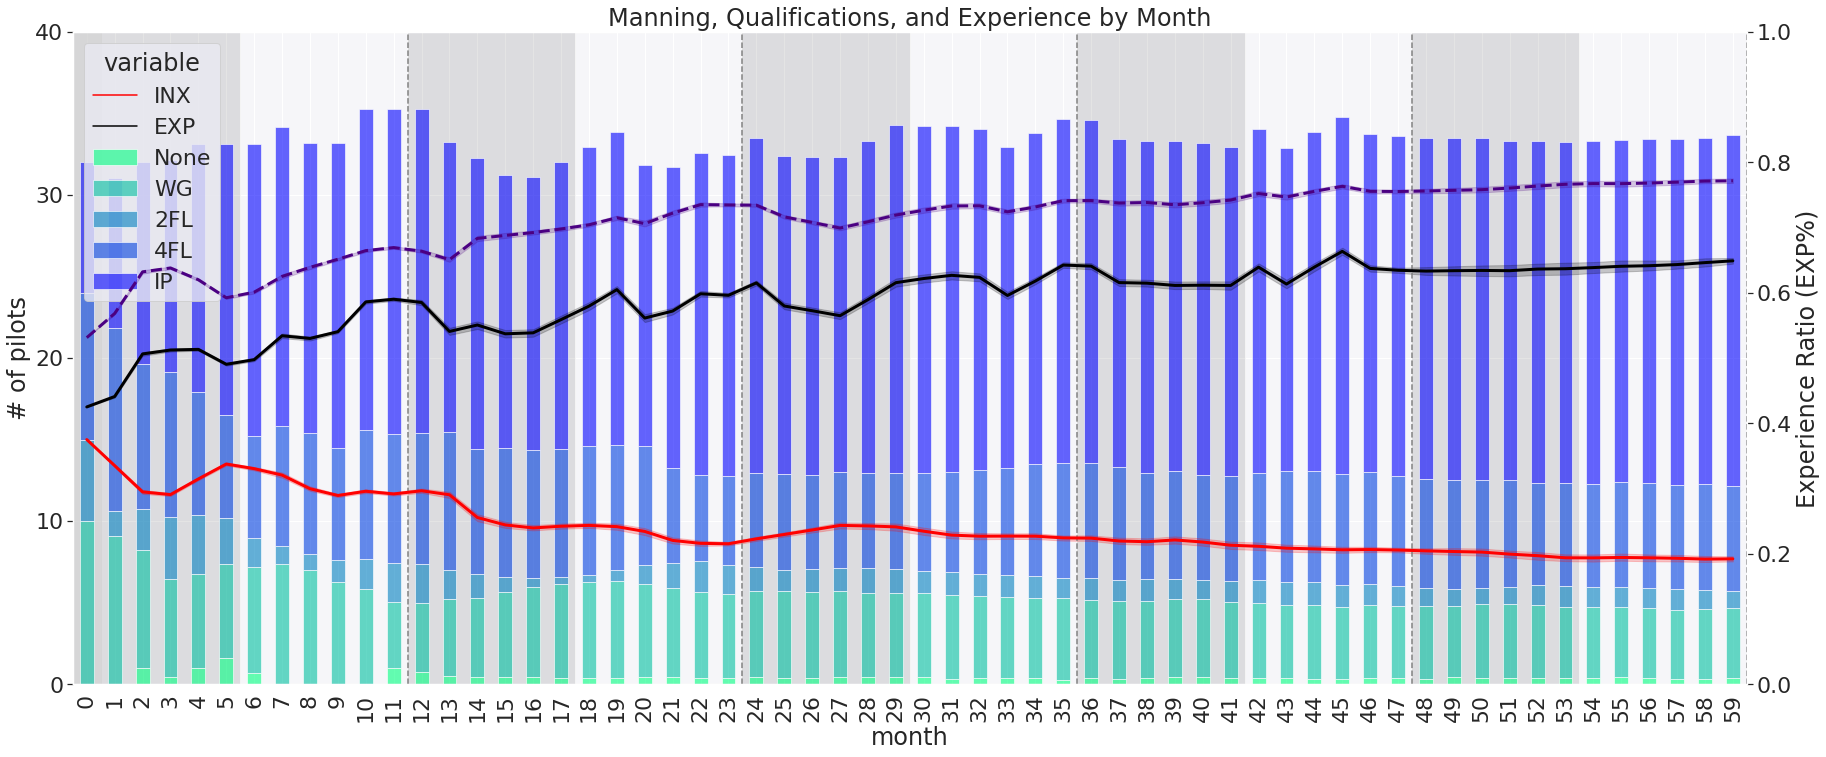

In [9]:
plt.rcParams['figure.figsize'] = (30, 12)
sns.set_theme()
sns.set(font_scale=2)
fig, ax = plt.subplots()
for year in range(1, int(len(quals_df) / 12)+1):
    ax.axvline(year*12 - 0.5, linestyle='--', lw=1.5, c='gray')
    start = (year-1)*12 - 0.5
    ax.axvspan(start, start+6, color='lightgray', alpha=0.6)
    ax.axvspan(start+6, start+12, color='white', alpha=0.6)
ax.axvspan(-0.5, 0.5, color='lightgray', alpha=0.6)
quals_df[['None', 'WG', '2FL', '4FL', 'IP']].plot(kind='bar', stacked=True, colormap='winter_r', alpha=0.6, ax=ax)
sns.lineplot(data=exp_df, x='month', y='value', hue='variable', ax=ax, linewidth=3, palette=['red', 'black'])
ax2 = ax.twinx()
sns.lineplot(data=exp_df, x='month', y='ratio', ax=ax2, color='indigo', linestyle='--', linewidth=3, alpha=1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylabel('# of pilots')
ax2.set_ylabel('Experience Ratio (EXP%)')
ax.set_title('Manning, Qualifications, and Experience by Month')
ax2.grid(False)

In [10]:
df = pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_INX']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM')
df['experience'] = 'INX'
df = pd.concat([df, pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_EXP']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM').assign(experience='EXP')])
scm_df = df.explode('SCM')
scm_df

,month,SCM,experience
0,0,4,INX
0,0,9,INX
0,0,6,INX
0,0,10,INX
0,0,4,INX
...,...,...,...
11999,59,7,EXP
11999,59,9,EXP
11999,59,4,EXP
11999,59,3,EXP


In [11]:
scm_df[scm_df['SCM'] > 20]

,month,SCM,experience


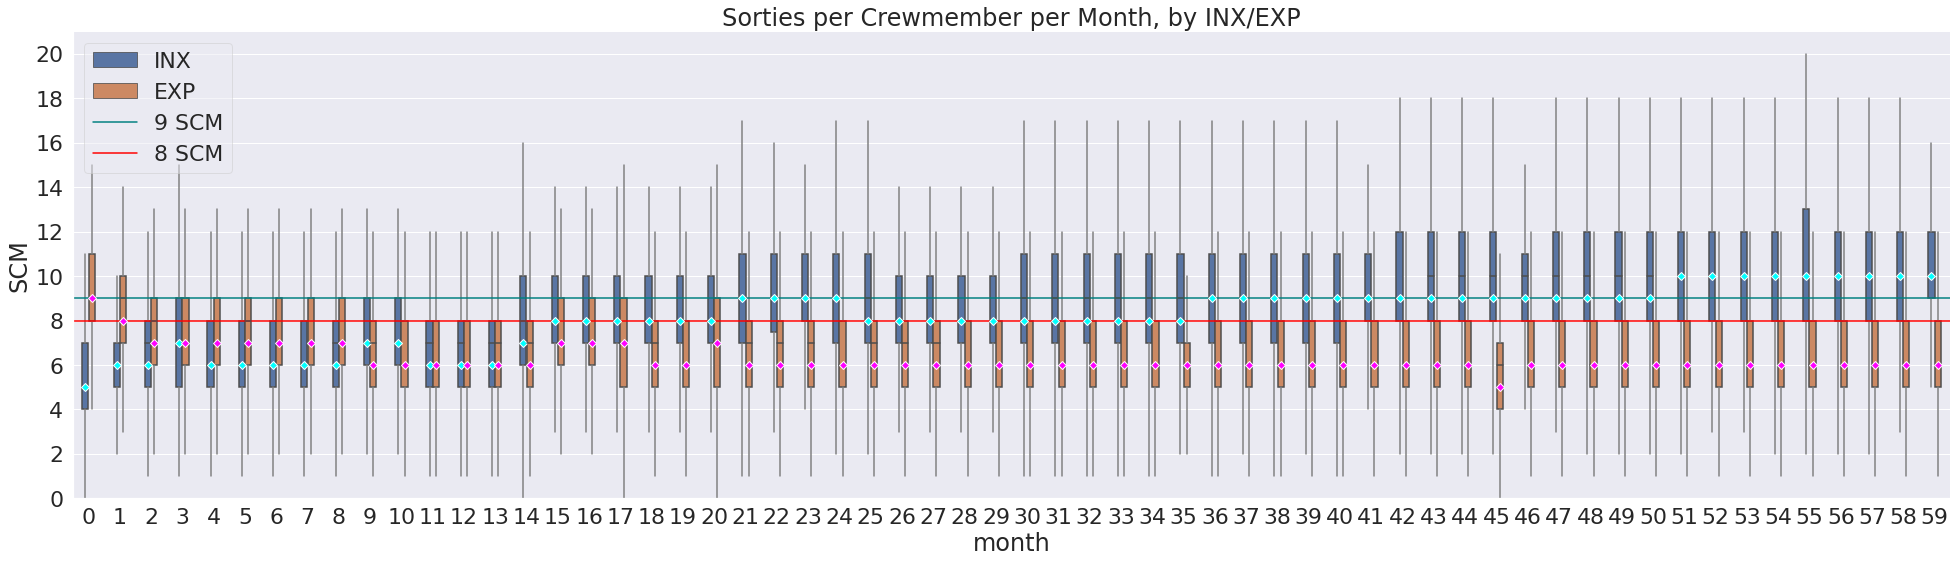

In [12]:
box = sns.catplot(data=scm_df, y='SCM', x='month', hue='experience', kind='box', width=0.4, showmeans=True, showcaps=False, showfliers=False, meanprops={'marker': 'D', 'markeredgecolor': 'white', 'markersize': 5}, whiskerprops={'color': 'grey'}, height=8, aspect=3.5, legend=False)
# == Code below modified from https://stackoverflow.com/questions/63038011/assign-color-of-mean-markers-while-using-seaborn-hue
num_artists = 2*len(quals_df)
num_lines = len(box.ax.lines)
lines_per_artist = num_lines // num_artists
marker_colors = ['cyan', 'magenta']*(num_artists//2)
for i in range(num_artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = marker_colors[i]
    # box.ax.lines[i*lines_per_artist + j].set_edgecolor(col)
    # box.ax.lines[i*lines_per_artist + j].set_facecolor('None')
    # set the marker colors of the corresponding "lines" to the same color
    for j in range(lines_per_artist):
        box.ax.lines[i * lines_per_artist + j].set_markerfacecolor(col)
        box.ax.lines[i * lines_per_artist + j].set_markeredgecolor('white')
# ==
box.ax.axhline(9, color='teal', label='9 SCM')
box.ax.axhline(8, color='red', label='8 SCM')
box.ax.set_yticks(range(0, 21, 2))
box.ax.set_ylim(0, 21)
box.ax.set_title('Sorties per Crewmember per Month, by INX/EXP')
plt.legend(framealpha=0.5)
plt.show()

In [13]:
#  ax = flows[['net_first', 'net_nth']].plot(kind='bar')
#  ax.axhline(0, color='black')
#  ax.set_xlabel('month')
#  ax.set_ylabel('net gain/loss by first v. nth tour')

#  flows[['first_cum', 'nth_cum']].plot(kind='line', ax=ax)

In [14]:
df = pd.DataFrame([row for run in many for row in run['pilot']['TTE'] if row['Absorbable']])
df['EXP year'] = df['EXP month'].floordiv(12)
absorbed_df = df
absorbed_df

,PID,Source,TTE,EXP month,Absorbable,EXP year
0,6,initial WG/2FL,33,2,True,0
1,8,initial WG/2FL,26,3,True,0
2,11,initial WG/2FL,27,3,True,0
3,4,initial WG/2FL,23,7,True,0
4,14,initial WG,24,8,True,0
...,...,...,...,...,...,...
4863,52,FTU,24,45,True,3
4864,57,FTU,25,53,True,4
4865,59,FTU,23,53,True,4
4866,64,FTU,23,58,True,4


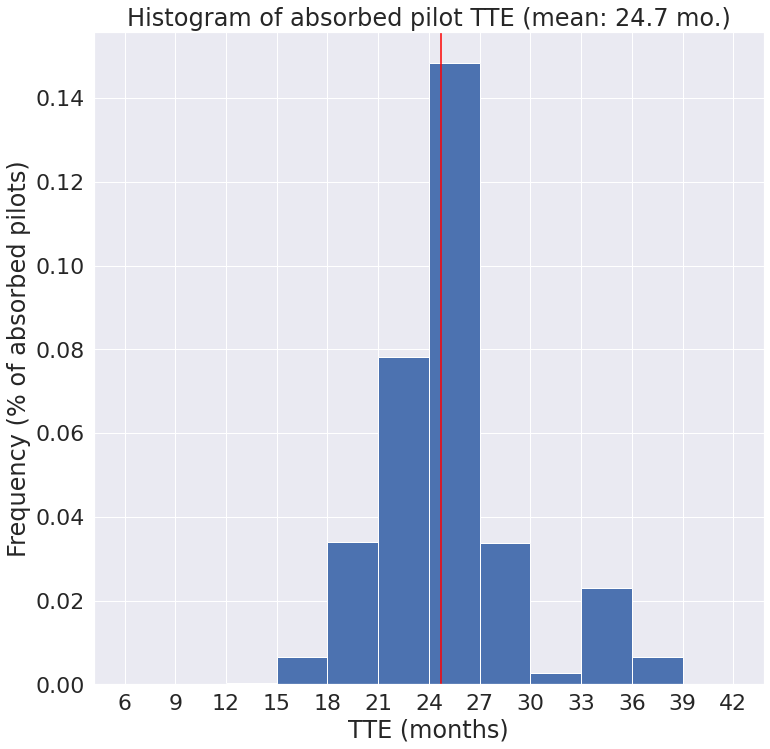

In [15]:
plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
absorbed_df['TTE'].plot.hist(bins=range(6, 45, 3), density=True, ax=ax)
ax.axvline(absorbed_df['TTE'].mean(), color='red')
ax.set_xlabel('TTE (months)')
ax.set_ylabel('Frequency (% of absorbed pilots)')
ax.set_title(f'Histogram of absorbed pilot TTE (mean: {absorbed_df["TTE"].mean():.1f} mo.)')
ax.set_xticks(range(6, 45, 3))
plt.show()

<AxesSubplot:ylabel='month'>

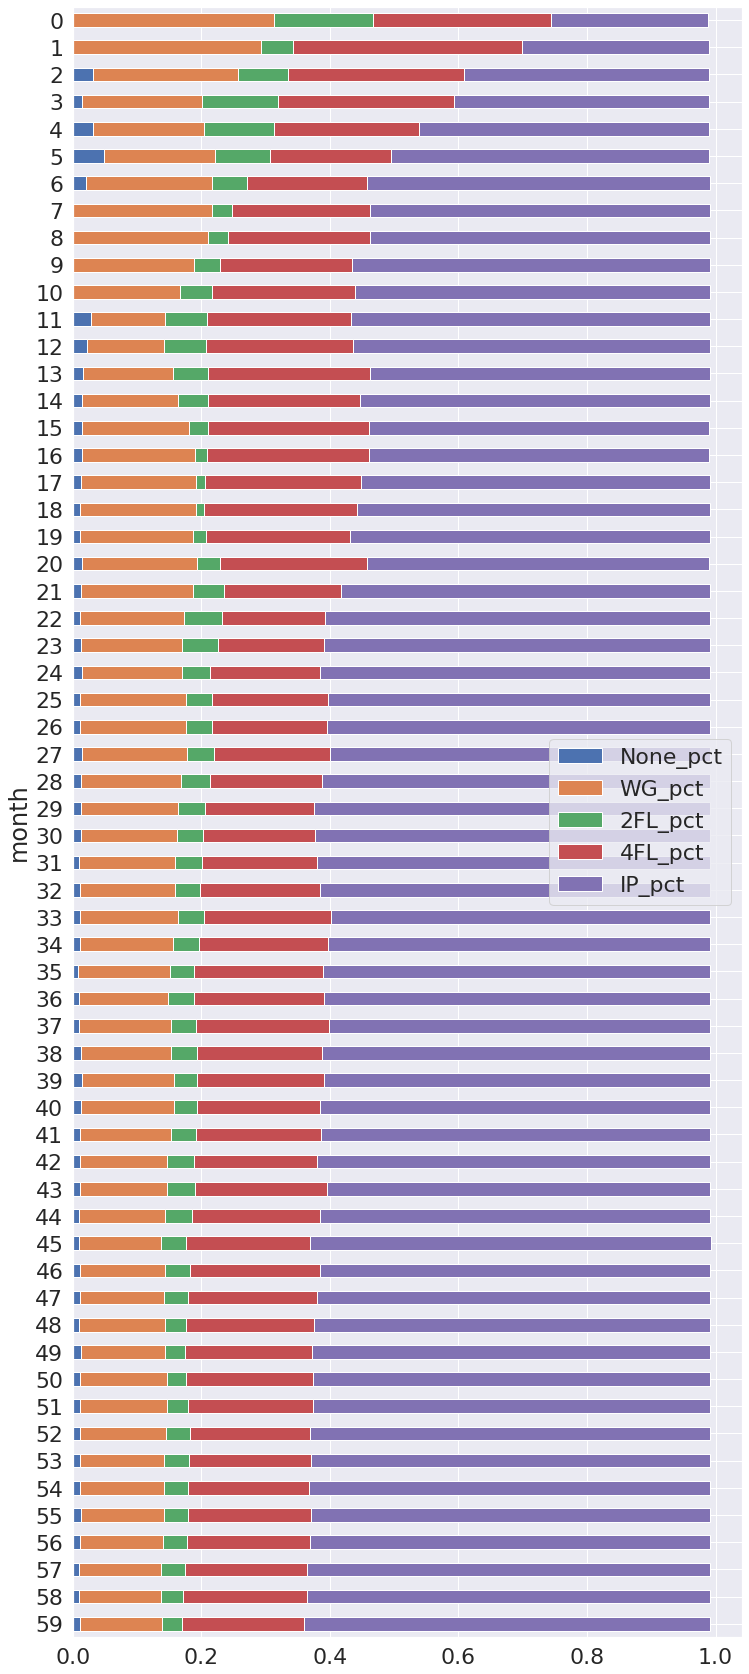

In [16]:
plt.rcParams['figure.figsize'] = (12, 30)
quals_df.loc[::-1, 'None_pct':].plot(kind='barh', stacked=True)

In [17]:
per_year = absorbed_df.groupby('EXP year').size() / num_runs
per_year

EXP year
0    5.035
1    6.000
2    3.725
3    4.675
4    4.530
5    0.375
dtype: float64

In [18]:
mean_absorption = per_year[:int(months_per_run/12)].mean()

<AxesSubplot:title={'center':'Absorption by Year (mean: 4.8 pilots per year)'}, xlabel='EXP year'>

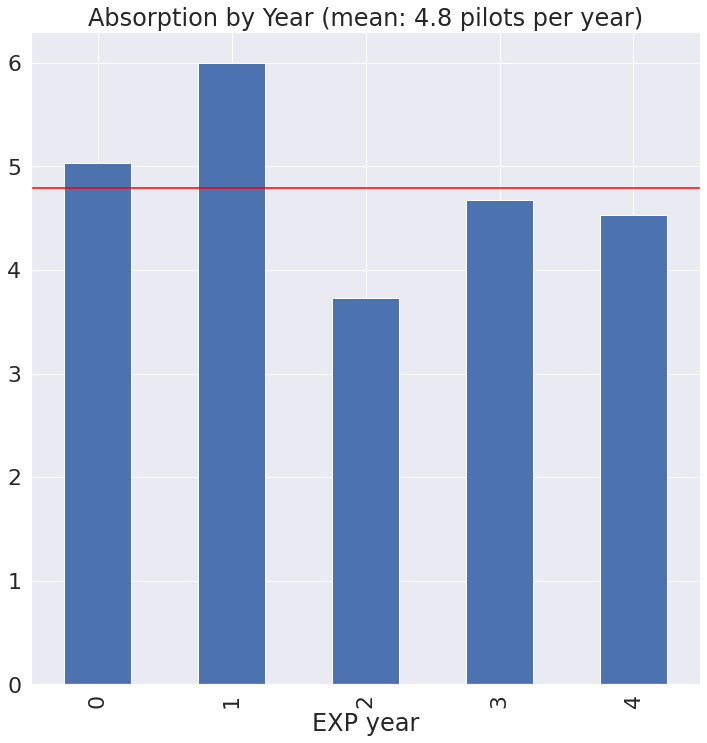

In [19]:
plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
ax.axhline(mean_absorption, color='red')
ax.set_title(f'Absorption by Year (mean: {mean_absorption:.1f} pilots per year)')
per_year[:int(months_per_run/12)].plot(ax=ax, kind='bar')